## Workbook to calculate the flare volume by year, and broken down by top_x counties. This was an early part of the capstone project before I settled on using Tableau; later I ended up just re-creating this work in Tableau.

## Setup / packages / crs

In [1]:
import geopandas as gp
from shapely import wkt
import pandas as pd
import pprint
import os
import glob
import openpyxl
import matplotlib.pyplot as plt
import plotly.express as px #if using plotly
import folium

In [2]:
pd.set_option('display.max_columns', None)

In [3]:
worldmap = gp.read_file(gp.datasets.get_path("naturalearth_lowres"))
usa = gp.read_file("data/cb_2018_us_nation_5m.shp")
us_states = gp.read_file("data/cb_2018_us_state_500k.shp")
ca_state = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_State_TIGER2016.shp")
ca_counties = gp.read_file("/Users/natebender/Desktop/repo/capstone_rmi/data/CA_Counties_TIGER2016.shp")

In [4]:
# set common crs for project
projcrs = 4326
us_states = us_states.to_crs(projcrs)  # match us_states common crs for project
worldmap = worldmap.to_crs(projcrs)
ca_state = ca_state.to_crs(projcrs)
ca_counties = ca_counties.to_crs(projcrs)

In [5]:
# read in Refineries

cols = list(pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", nrows =1))
refs = pd.read_csv("data/asset-climate-trace_oil-refining_091922.csv", 
                   usecols = lambda x: x not in ['other1', 'other2', 'other3', 
                                                 'other4', 'other5', 'other6', 'other7'])
refs['location'] = gp.GeoSeries.from_wkt(refs['location'])  # convert existing points to geoseries
refs = gp.GeoDataFrame(refs, geometry="location", crs=projcrs)  # convert df to geodf

In [6]:
# read in cleaned and combined flares data
all_flares = gp.read_file("data/all_flares.shp")

In [7]:
# check 
all_flares.head(3)

,Country,ISO Code,Catalog ID,id #,Latitude,Longitude,BCM_2019,avg_temp,Ellipticit,Detection_,clr_obs19,Type,ID 2020,BCM_2020,Avg. temp.,Det_freq20,clr_obs20,ID 2021,BCM_2021,Det_freq21,clr_obs21,id_key_201,Avg_Temp_K,Det_freq17,clr_obs17,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,clr_obs12,clr_obs13,clr_obs14,clr_obs15,clr_obs16,Det_freq12,Det_freq13,Det_freq14,Det_freq15,Det_freq16,Catalog _1,BCM_2018,Det_freq18,clr_obs18,flare_cate,Detection,Det_freq19,flare_id,geometry
0,Venezuela,VEN,VEN_UPS_2015_63.6235W_9.6520N_v0.2,3591.0,9.652042,-63.623525,1.167234,1839.27,1.60150,100.0000,112.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,7266d5ad873630,POINT (-63.62353 9.65204)
1,Iraq,IRQ,IRQ_UPS_2015_47.2834E_31.0259N_v0.2,6116.0,31.025901,47.283392,1.092002,1651.94,4.78228,83.5821,67.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,b02de8d9377869,POINT (47.28339 31.02590)
2,Iran,IRN,IRN_UPS_2015_49.7141E_28.4940N_v0.2,6450.0,28.494039,49.714096,0.947876,1658.76,2.31782,100.0000,265.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,NaN,NaN,5754a320128030,POINT (49.71410 28.49404)


In [8]:
len(all_flares)

74289

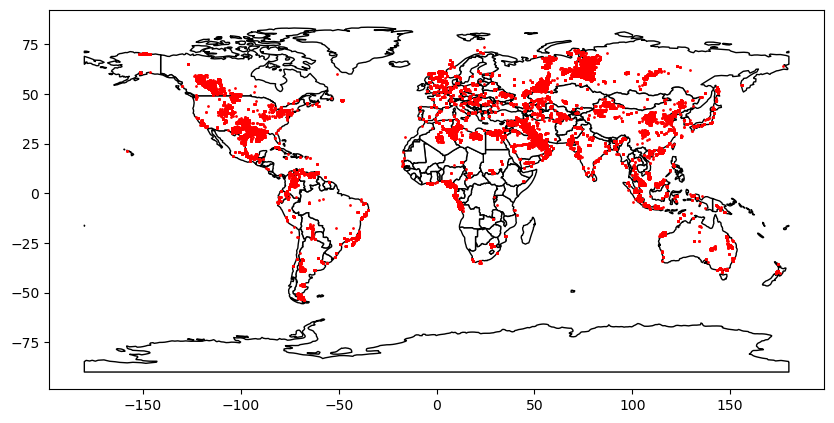

In [9]:
# see where the flares are across the world

fig, ax = plt.subplots(figsize = (10,8))
worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
all_flares.plot(ax = ax, color='red', markersize=1)  # increase size for visibility
plt.show()

### US / CA analysis

In [10]:
# # subset to just lower 48 plus AK
# # remove territories (PR, PW, VI, MH, GU) and AK, HI
# stateslist = ["AL","AR","AZ","CA","CO","CT","DC","DE","FL","GA","IA","ID", "IL","IN","KS","KY","LA","MA","MD","ME","MI","MN","MO","MS","MT","NC","ND","NE","NH","NJ","NM","NV","NY", "OH","OK","OR","PA","RI","SC","SD","TN","TX","UT","VA","VT","WA","WI","WV","WY"]
# us_states = us_states[us_states['STUSPS'].isin(stateslist)]

In [11]:
# match all flares and refineries with just CA counties
inner_join_result = gp.sjoin(all_flares, ca_counties, how = "inner", predicate = 'within')
refs_join = gp.sjoin(refs, ca_counties, how='inner', predicate='within')
print(f'Flares found: {len(inner_join_result)}')

Flares found: 117


In [12]:
len(inner_join_result)

117

In [13]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# calc mean by year
inner_join_result['BCM_avg'] = inner_join_result[col_list].mean(axis=1)

### Visualization

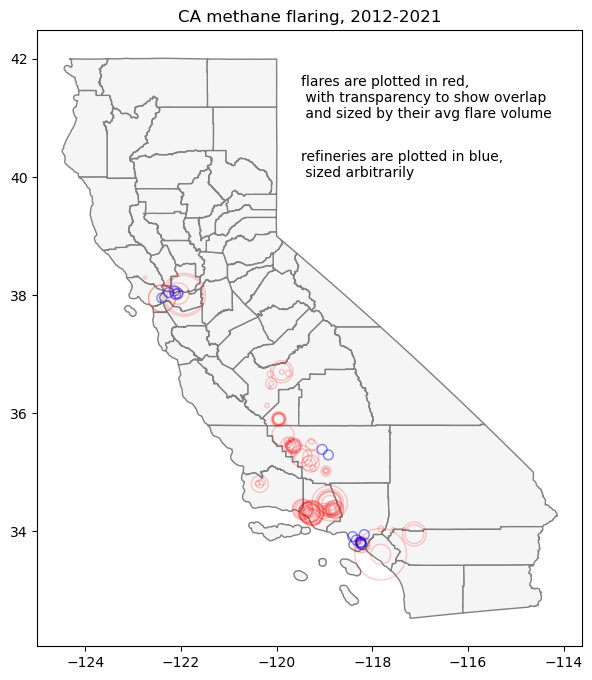

In [14]:
# # Plotting multiple layers

fig, ax = plt.subplots(figsize = (10,8))
#worldmap.plot(ax = ax, color = 'white', edgecolor = 'black')
#us_states.plot(ax = ax, color = 'whitesmoke', edgecolor = 'black')
ca_counties.plot(ax = ax, color = 'whitesmoke', edgecolor = 'grey')
# increase size by 100000 just for readability
inner_join_result.plot(ax = ax, facecolors='none', color = 'red', alpha=.2, markersize=inner_join_result[col_list].mean(axis=1)*100000)
refs_join.plot(ax = ax, facecolors = 'none', color = 'blue', alpha = .08, markersize=50)
#plt.ylim([33, 39])  # can zoom for readability
plt.title("CA methane flaring, 2012-2021")
plt.text(-119.5,41, 'flares are plotted in red,\n with transparency to show overlap\n and sized by their avg flare volume')
plt.text(-119.5,40, 'refineries are plotted in blue,\n sized arbitrarily')
plt.show()

## California: BCM by county

In [15]:
refs

,start_date,end_date,asset_identifier,asset_name,iso3_country,location,type,capacity,capacity_factor,activity,CO2_emissions_factor,CH4_emissions_factor,N2O_emissions_factor,other_gas_emissions_factor,CO2_emissions,CH4_emissions,N2O_emissions,other_gas_emissions,total_CO2e_100yrGWP,total_CO2e_20yrGWP
0,1/1/2015,12/31/2015,200,Ghazanfar Oil Refinery,AFG,POINT (67.40827 37.20814),NaN,12000,NaN,NaN,NaN,NaN,NaN,NaN,1.514418e+04,38.712121,0.200056,NaN,1.635742e+04,1.839255e+04
1,1/1/2015,12/31/2015,201,Armo Ballsh Refinery,ALB,POINT (19.75585 40.60490),NaN,20000,NaN,NaN,NaN,NaN,NaN,NaN,1.056636e+05,174.804336,0.936051,NaN,1.111518e+05,1.203405e+05
2,1/1/2015,12/31/2015,202,Sonatrach Skikda Refinery,DZA,POINT (6.97438 36.87311),NaN,350000,NaN,NaN,NaN,NaN,NaN,NaN,3.828858e+06,6240.602919,37.806111,NaN,4.026095e+06,4.354029e+06
3,1/1/2015,12/31/2015,203,Skikda Condensate Refinery,DZA,POINT (6.97247 36.86314),NaN,100000,NaN,NaN,NaN,NaN,NaN,NaN,7.201545e+05,1840.885817,9.513303,NaN,7.778479e+05,8.746247e+05
4,1/1/2015,12/31/2015,204,Sonatrach Algiers Refinery Algeria,DZA,POINT (3.11826 36.67530),NaN,59000,NaN,NaN,NaN,NaN,NaN,NaN,6.454361e+05,1051.987349,6.373030,NaN,6.786845e+05,7.339649e+05
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4139,1/1/2021,12/31/2021,128,Western Refining Southwest Inc Gallup,USA,POINT (-108.42601 35.48893),NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00
4140,1/1/2021,12/31/2021,129,Tesoro Refining & Marketing Co Martinez,USA,POINT (-122.06412 38.02608),NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00
4141,1/1/2021,12/31/2021,130,Hollyfrontier Cheyenne Refining Llc Cheyenne,USA,POINT (-104.78910 41.12832),NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00
4142,1/1/2021,12/31/2021,131,Philadelphia Energy Solutions Philadelphia,USA,POINT (-75.19888 39.91696),NaN,0,NaN,NaN,NaN,NaN,NaN,NaN,0.000000e+00,0.000000,0.000000,NaN,0.000000e+00,0.000000e+00


In [16]:
# just CA flares
ca_flares = gp.read_file("data/ca_flares_clean.shp")

# renaming 
ca_flares.rename(columns={'NAMELSAD':'county_name'}, inplace=True)  # old:new. Match col names for merging

print(f'Flares found: {len(ca_flares)}')

Flares found: 117


In [17]:
# Create df of total BCM by year, grouped by CA county

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = ca_flares.groupby(['county_name'])[col_list].sum()
stats['Total_bcm'] = stats.loc[:,col_list].sum(axis=1)

In [18]:
stats.sort_values('Total_bcm', ascending=False)

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_bcm
county_name,,,,,,,,,,,
Ventura County,0.012710,0.010459,0.014991,0.014626,0.010991,0.007965,0.013832,0.012244,0.010266,0.007006,0.115091
Kern County,0.022107,0.017479,0.006143,0.004658,0.004097,0.001750,0.001857,0.001513,0.001847,0.002424,0.063874
Contra Costa County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.016525,0.012624,0.029149
Orange County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.013800,0.002061,0.015861
Kings County,0.000113,0.000184,0.000466,0.002189,0.001324,0.000832,0.001163,0.000762,0.000651,0.000527,0.008210
Los Angeles County,0.000461,0.000566,0.000928,0.000969,0.001372,0.000441,0.000450,0.000000,0.001092,0.001398,0.007675
Fresno County,0.000000,0.000000,0.000000,0.000000,0.002157,0.000000,0.000356,0.000627,0.001563,0.002572,0.007275
Riverside County,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.001856,0.000000,0.000000,0.002968,0.004824
Santa Barbara County,0.000279,0.000206,0.000099,0.000000,0.000000,0.000304,0.001694,0.000000,0.000000,0.000000,0.002583


In [19]:
#forplot = stats.drop(['Total_bcm'], axis=1)
#forplot.loc['total'] = forplot.sum()

# sort by Total_bcm and select the top 5 rows
top_5_counties = stats.sort_values('Total_bcm', ascending=False).head(5).index.tolist()

# select only the top 5 counties for plotting
forplot = stats.loc[top_5_counties, col_list].transpose() 

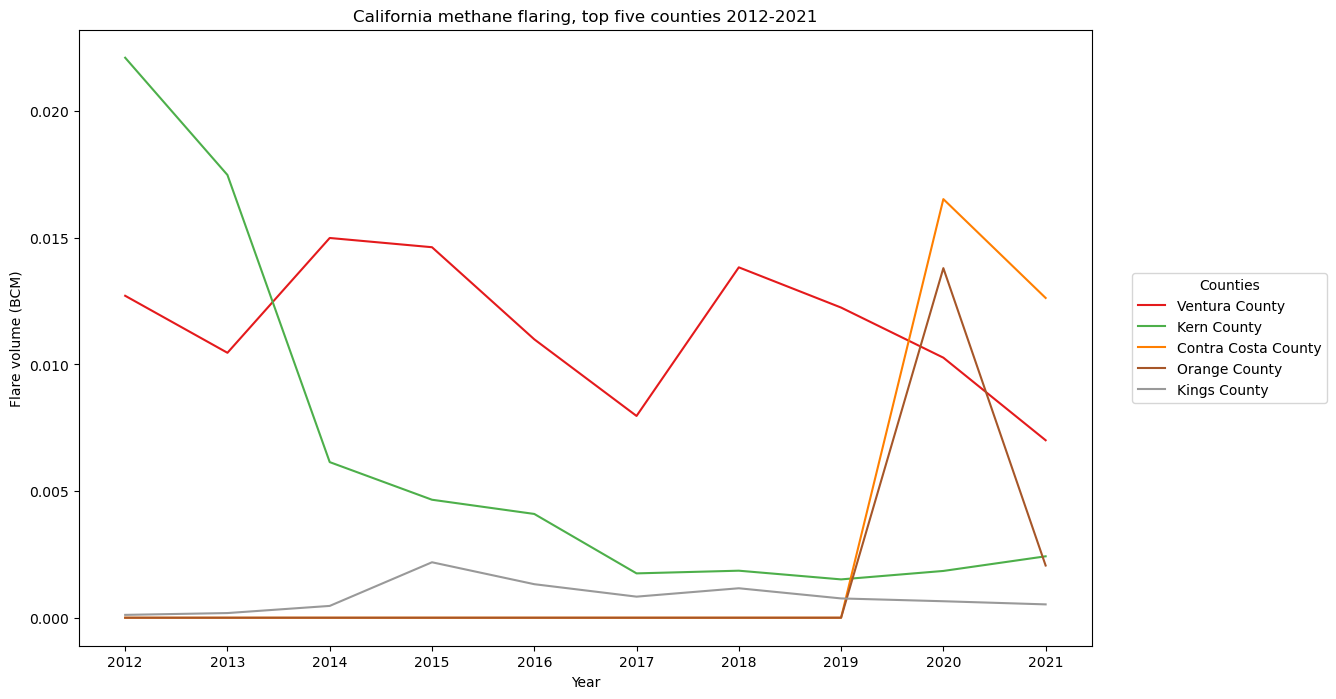

In [20]:
#forplot = forplot.transpose() 

col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

fig, ax = plt.subplots(figsize=(15, 8))
plot = forplot.plot(kind='line', ax=ax, title='California methane flaring, top five counties 2012-2021', colormap='Set1')

legend = plot.legend(bbox_to_anchor=(1.04, 0.5), loc='center left', borderaxespad=0, title='Counties')
plt.subplots_adjust(right=0.8)

ax.set_ylabel('Flare volume (BCM)')
ax.set_xlabel('Year')
ax.set_xticks(range(len(col_list)))
ax.set_xticklabels([col.split('_')[1] for col in col_list])  # extract the year values from the col names

plt.savefig('flarevol_top5counties.png', bbox_inches='tight', dpi=300)



## California: BCM by flare category (upstream all, downstream oil)

In [21]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

stats = ca_flares.groupby(['flare_cate'])[col_list].sum()
stats['Total_cat'] = stats.loc[:,col_list].sum(axis=1)
stats.loc['Total'] = stats.sum()

In [22]:
# table of BCM totals by flare category and year. Ignore the meaningless value at the intersection of
# the two totals
stats

,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,BCM_2017,BCM_2018,BCM_2019,BCM_2020,BCM_2021,Total_cat
flare_cate,,,,,,,,,,,
flares_oil_downstream,0.000461,0.000566,0.000928,0.000969,0.000254,0.000441,0.000680,0.000000,0.008098,0.006118,0.018512
flares_upstream,0.035209,0.028328,0.021700,0.021474,0.020296,0.010852,0.020528,0.015145,0.037646,0.025462,0.236638
Total,0.035669,0.028893,0.022628,0.022442,0.020550,0.011293,0.021207,0.015145,0.045744,0.031579,0.255151


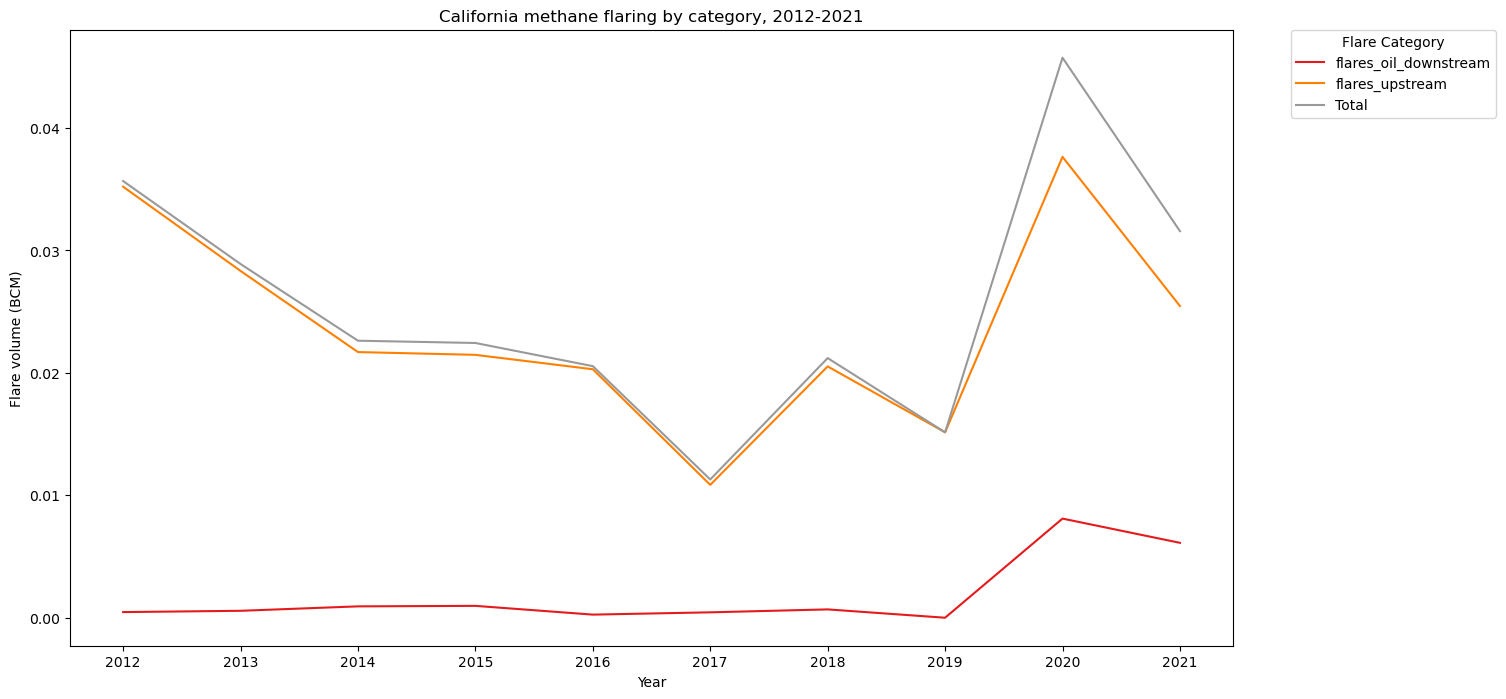

In [23]:
forplot = stats.drop(['Total_cat'], axis=1)
forplot = forplot.transpose() 

#plot.savefig('flarevol_year_category.png', dpi=300, bbox_inches='tight')

forplot = stats.drop(['Total_cat'], axis=1)
forplot = forplot.transpose()

fig, ax = plt.subplots(figsize=(15, 8))
plot = forplot.plot(kind='line', ax=ax, title='California methane flaring by category, 2012-2021', colormap='Set1')

ax.set_ylabel('Flare volume (BCM)')
ax.set_xlabel('Year')
ax.set_xticks(range(len(col_list)))
ax.set_xticklabels([col.split('_')[1] for col in col_list])  # extract the year values from the col names
legend = plot.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0, title='Flare Category')

plt.savefig('flarevol_year_category.png', dpi=300, bbox_inches='tight')

## Volume over time for individual flares

In [24]:
ca_flares.sample(1)

,Country,ISO Code,Catalog ID,id #,Latitude,Longitude,BCM_2019,avg_temp,Ellipticit,Detection_,clr_obs19,Type,ID 2020,BCM_2020,Avg. temp.,Det_freq20,clr_obs20,ID 2021,BCM_2021,Det_freq21,clr_obs21,id_key_201,Avg_Temp_K,Det_freq17,clr_obs17,ISO_Code,BCM_2017,id_key,BCM_2012,BCM_2013,BCM_2014,BCM_2015,BCM_2016,clr_obs12,clr_obs13,clr_obs14,clr_obs15,clr_obs16,Det_freq12,Det_freq13,Det_freq14,Det_freq15,Det_freq16,Catalog _1,BCM_2018,Det_freq18,clr_obs18,flare_cate,Detection,Det_freq19,flare_id,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,county_name,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,BCM_avg,geometry
2,United States,USA,USA_UPS_2015_118.7840W_34.3740N_v0.2,1012.0,34.374022,-118.784005,0.001616,1822.63,1.6015,14.8045,358.0,upstream,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,NaN,NaN,NaN,flares_upstream,None,None,923deb62607933,06,111,00277320,06111,Ventura,Ventura County,06,H1,G4020,348,37100,None,A,4773390489,945942791,+34.3587415,-119.1331432,0.001616,POINT (111804.156 -403954.218)


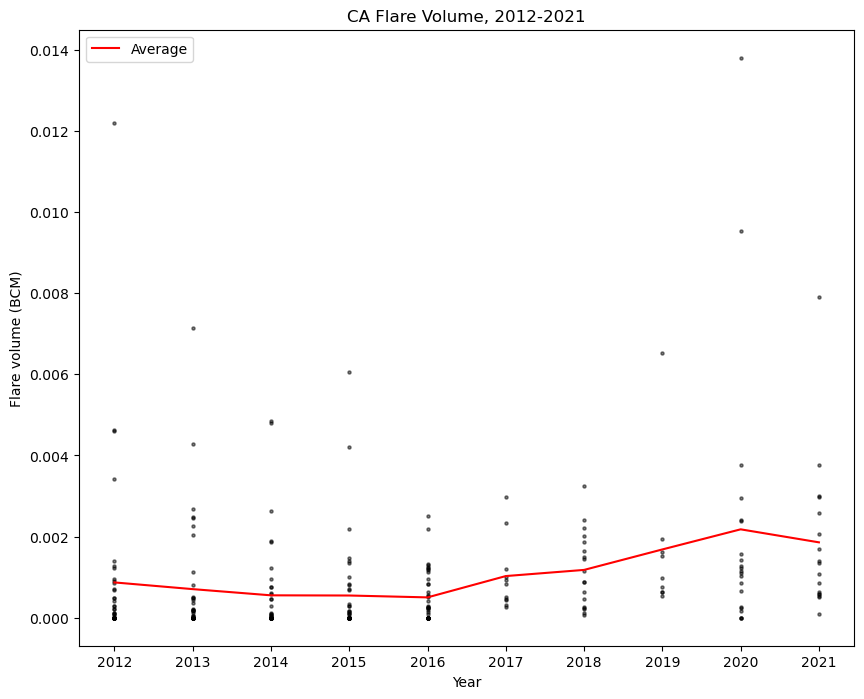

In [25]:

# Define the list of columns to use
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']

# Create a scatterplot of flare volume values over time
fig, ax = plt.subplots(figsize=(10,8)) # Adjust the plot size
for i, year in enumerate(col_list):
    ax.scatter([i] * len(ca_flares), ca_flares[year], s=5, alpha=0.5, color='black')

# Add a trend line of the average across the whole dataframe for all years
mean_vals = ca_flares[col_list].mean(axis=0)
ax.plot(range(len(col_list)), mean_vals, color='r', label='Average')

# Set the x-axis labels to the corresponding year
ax.set_ylabel('Flare volume (BCM)')
ax.set_xlabel('Year')
ax.set_xticks(range(len(col_list)))
ax.set_xticklabels([col.split('_')[1] for col in col_list])  # extract the year values from the col namesax.set_xticklabels(col_list, rotation=30, ha='right')


# Set the axis labels and title
ax.set_xlabel('Year')
ax.set_ylabel('Flare volume (BCM)')
ax.set_title('CA Flare Volume, 2012-2021')

# Add a legend
ax.legend()

plt.savefig('flarevol_year.png', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()



#### Interrogating some flare_ids for troubleshooting in Tableau

In [27]:
col_list = ['BCM_2012','BCM_2013','BCM_2014','BCM_2015','BCM_2016','BCM_2017',
            'BCM_2018','BCM_2019','BCM_2020','BCM_2021']


# col_list = ['BCM_2019','BCM_2020','BCM_2021']

for item in col_list:
    non_null_count = ca_flares[item].count()
    print(f"Total non-null values in {item}: {non_null_count}")

Total non-null values in BCM_2012: 41
Total non-null values in BCM_2013: 41
Total non-null values in BCM_2014: 41
Total non-null values in BCM_2015: 41
Total non-null values in BCM_2016: 41
Total non-null values in BCM_2017: 11
Total non-null values in BCM_2018: 18
Total non-null values in BCM_2019: 9
Total non-null values in BCM_2020: 21
Total non-null values in BCM_2021: 17


In [28]:
for item in col_list:
    non_null_count = ca_flares[item].count()
    if non_null_count > 0:
        flare_ids = ca_flares[ca_flares[item].notnull()]['flare_id']
        print(f"flare_ids for non-null values in {item}:")
        print(flare_ids)

flare_ids for non-null values in BCM_2012:
24     17924e83231001
25     0c9875df894488
26     f4184210304386
27     c3938182202850
28     b90fba59467112
29     c4b72888273261
30     1adcdb4e420679
31     0998310f509776
32     a320b4af262896
33     72a4ac68558230
34     4bdc2073111380
52     a7066004406177
53     5d18f276200055
54     e28788b0596146
55     27e459bf913084
56     556c8fa4532172
57     276175c4524407
58     21936479701977
59     71650042757995
60     811e800d222151
61     ff22a89d196030
62     2235394a202227
63     2d76ec61340565
64     4b21a977663369
73     68a40fb5412802
80     64be8363283749
81     1fad7506781258
82     0cc3440c880993
83     ff70d6a0183790
88     96581e2d782755
97     9b8764a5112862
101    29fd92d5295983
104    cfe93e6f458336
105    5dde829f142492
109    14cc52aa128139
110    599944c3595483
111    facedb82167979
112    4823d3b1510417
114    177274e9166258
115    938b0307266912
116    ea5bf2dc235149
Name: flare_id, dtype: object
flare_ids for non-null va